In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData
from pyuvdata import uvutils
from hera_qm import ant_metrics
import hera_cal
from copy import deepcopy
from scipy import stats
from astropy.io import fits

from matplotlib.colors import SymLogNorm
import sys
import os
from hera_qm import xrfi as xrfi
import numpy.ma as ma
from glob import glob
import math


In [2]:

data_file_list = ['/data6/HERA/data/2458042/zen.2458042.12552.xx.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.yy.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.yx.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.xy.HH.uv']

uv = UVData()

uv.read_miriad(data_file_list)


Combined polarizations are not evenly spaced. This will make it impossible to write this data out to some file types.


In [3]:

aa = hera_cal.utils.get_aa_from_uv(uv)

info = hera_cal.omni.aa_to_info(aa)

reds = info.get_reds()


In [4]:

am = ant_metrics.Antenna_Metrics(data_file_list, reds, fileformat = 'miriad')

am.xants = []


In [5]:

v = deepcopy(uv)


In [6]:

bases = []

lst = uv.get_antpairpols()

for i in range(uv.Nbls):
    
    pair = lst[4*i]
    
    bases.append((pair[0],pair[1]))


In [7]:

nonreds = []

for i in bases:
    
    flag = 0
    
    for j in reds:
        
        for k in j:
            
            if i == k:
                
                flag = 1
                
    if flag == 0:
        
        nonreds.append(i)


In [8]:

def signal(amp,width,baseline):
    
    ant_1 = baseline[0]
    
    ant_2 = baseline[1]
    
    ant_1_ind = np.where(uv.antenna_numbers==ant_1)
    
    ant_2_ind = np.where(uv.antenna_numbers==ant_2)
    
    if (ant_1 == ant_2):
        
        return np.zeros((60,1024,4))
    
    dist = np.linalg.norm(uv.antenna_positions[ant_1_ind]-uv.antenna_positions[ant_2_ind])
    
    c = float(3e8)
    
    B = float(uv.freq_array[0][-1]-uv.freq_array[0][1])
    
    del_tau = 2.*np.pi / B
    
    tau = dist / c
    
    temp = np.zeros((60,1024,4))
    
    T = uv.Ntimes*10
    
    del_nu = 2.*np.pi / T
    
    earth_rot = 2*np.pi / 86164.09053
    
    freq_naught = np.median(uv.freq_array[0])
    
    nu = earth_rot * dist * freq_naught / c
    
    for i in range(uv.Ntimes/2):
        
        for j in range(int(math.ceil(float(tau/del_tau)))):
            
            temp[i][j][0]= np.random.normal(amp,width) * np.exp(-i*(del_nu/nu))
            
            if (i != 0):
            
                temp[-i][j][0] = np.random.normal(amp,width) * np.exp(-i*(del_nu/nu))
            
    result = np.fft.fftn(temp)
    
    return result


In [9]:

nu_rang = np.zeros((60,1024,4))
    
tau_rang = np.zeros((60,1024,4))
    
for i in range(uv.Ntimes):
        
    nu_rang[i,:,:] = -i
        
for j in range(uv.Nfreqs/2 + 1):
        
    tau_rang[:,j,:] = j
    
    if (j != 0):
        
        tau_rang[:,-j,:] = j
  

In [10]:

def signal(amp,width,baseline):
    
    ant_1 = baseline[0]
    
    ant_2 = baseline[1]
    
    if (ant_1 == ant_2):
        
        return np.zeros((60,1024,4))
    
    ant_1_ind = np.where(uv.antenna_numbers==ant_1)
    
    ant_2_ind = np.where(uv.antenna_numbers==ant_2)
    
    dist = np.linalg.norm(uv.antenna_positions[ant_1_ind]-uv.antenna_positions[ant_2_ind])
    
    c = float(3e8)
    
    B = float(uv.freq_array[0][-1]-uv.freq_array[0][1])
    
    del_tau = 1. / B
    
    tau = (c * del_tau) / (dist * np.cos(15*np.pi / 180))
    
    temp = np.zeros((60,1024,4),dtype = complex)
    
    T = uv.Ntimes*10
    
    del_nu = 1. / T
    
    earth_rot = 1. / 86164.09053
    
    freq_naught = np.median(uv.freq_array[0])
    
    nu = earth_rot * dist * freq_naught / c
    
    temp = np.random.normal(amp,width,(60,1024,4)) * np.exp(nu_rang*(del_nu/nu)) * np.sinc(tau_rang*tau)
    
    result = np.fft.fftn(temp)
    
    return result
    

In [11]:

def noise(amp,width):
    
    result = np.random.normal(amp,width,(60,1024,4))
    
    return result


In [12]:

ants = uv.antenna_numbers

ant_delay = {}

for i in ants:
    
    ant_delay[i] = np.random.normal(0,2e-7)
    #ant_delay[i] = np.random.randint(10)
    

In [13]:

def generate_random_data(i_width,x_width):    
    
    new_data_array = np.zeros((67680, 1, 1024, 4),dtype = complex)
    
    s_amp = 0
    
    s_width = 1
    
    i_amp = 0
    
    n_amp = 0
    
    n_width = 0.1
    
    xant = 23

    x_amp = 0
    
    snr = 10
    
    for i in reds:
        
        sig = signal(s_amp,s_width,i[0])
        
        for j in i:
            
            sig[:,:,0] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            sig[:,:,1] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            sig[:,:,2] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            sig[:,:,3] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
            
            indices = v.antpair2ind(j[0],j[1])
        
            i_sig = signal(i_amp,i_width,j)
            
            i_sig[:,:,0] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            i_sig[:,:,1] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            i_sig[:,:,2] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            i_sig[:,:,3] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
            
            if ((j[0] == xant) or (j[1] == xant)):
            
                x_sig = signal(x_amp,x_width,j)
            
                x_sig[:,:,0] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
                x_sig[:,:,1] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
                x_sig[:,:,2] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
                x_sig[:,:,3] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
            
                norm_power = float(s_width**2)
            
                new_power = float(norm_power + i_width**2 + x_width**2)
            
                ratio = np.sqrt(norm_power/new_power)
            
                sigs = (sig + i_sig + x_sig) * ratio
            
            else:
            
                norm_power = float(s_width**2)
            
                new_power = float(norm_power + i_width**2)
            
                ratio = np.sqrt(norm_power/new_power)
            
                sigs = (sig + i_sig) * ratio
            
            noi = noise(n_amp,n_width)
        
            noi_power = np.mean(np.abs(noi))
        
            sig_power = np.mean(np.abs(sigs))
        
            noi_mod = snr/(sig_power/noi_power)
        
            noi /= noi_mod
            
            visibility = sigs + noi
            
            new_data_array[indices,0,:,:] = visibility
            
            
    for k in nonreds:
        
        sig = signal(s_amp,s_width,k)
        
        i_sig = signal(i_amp,i_width,j)
        
        norm_power = float(s_width**2)
        
        new_power = float(norm_power + i_width**2)
        
        ratio = np.sqrt(norm_power/new_power)
        
        sigs = (sig + i_sig) * ratio
        
        indices = v.antpair2ind(k[0],k[1])
        
        noi = noise(n_amp,n_width)
        
        noi_power = np.mean(np.abs(noi))
        
        sig_power = np.mean(np.abs(sigs))
        
        noi_mod = snr/(sig_power/noi_power)
        
        noi /= noi_mod
        
        visibility = sig
        
        new_data_array[indices,0,:,:] = visibility
        
        return new_data_array

In [14]:

def new_compute_median_auto_power_dict(data, pols, reds):
    
    autoPower = {}
    for pol in pols:
        for bls in reds:
            for (i, j) in bls:
                autoPower[i, j, pol] = np.median(np.mean(np.abs(data.get_data(i, j, pol))**2, axis=1))
    return autoPower


In [15]:
def new_red_corr_metrics(data, pols, antpols, ants, reds, xants=[], rawMetric=False, crossPol=False):

    # Compute power correlations and assign them to each antenna
    autoPower = new_compute_median_auto_power_dict(data, pols, reds)
    antCorrs = {(ant, antpol): 0.0 for ant in ants for antpol in antpols if
                (ant, antpol) not in xants}
    antCounts = deepcopy(antCorrs)
    for pol0 in pols:
        for pol1 in pols:
            iscrossed_i = (pol0[0] != pol1[0])
            iscrossed_j = (pol0[1] != pol1[1])
            onlyOnePolCrossed = (iscrossed_i ^ iscrossed_j)
            # This function can instead record correlations for antennas whose counterpart are pol-swapped
            if (not crossPol and (pol0 is pol1)) or (crossPol and onlyOnePolCrossed):
                for bls in reds:
                    for n, (ant0_i, ant0_j) in enumerate(bls):
                        data0 = data.get_data(ant0_i, ant0_j, pol0)
                        for (ant1_i, ant1_j) in bls[n + 1:]:
                            data1 = data.get_data(ant1_i, ant1_j, pol1)
                            corr = np.median(np.mean(np.abs(data0) * np.abs(data1),axis=1))
                            
                            corr /= np.sqrt(autoPower[ant0_i, ant0_j, pol0] *
                                            autoPower[ant1_i, ant1_j, pol1])
                            antsInvolved = [(ant0_i, pol0[0]), (ant0_j, pol0[1]),
                                            (ant1_i, pol1[0]), (ant1_j, pol1[1])]
                            if not np.any([(ant, antpol) in xants for ant, antpol
                                           in antsInvolved]):
                                # Only record the crossed antenna if i or j is crossed
                                if crossPol and iscrossed_i:
                                    antsInvolved = [(ant0_i, pol0[0]),
                                                    (ant1_i, pol1[0])]
                                elif crossPol and iscrossed_j:
                                    antsInvolved = [(ant0_j, pol0[1]), (ant1_j, pol1[1])]
                                for ant, antpol in antsInvolved:
                                    antCorrs[(ant, antpol)] += corr
                                    antCounts[(ant, antpol)] += 1

    # Compute average and return
    for key, count in antCounts.items():
        if count > 0:
            antCorrs[key] /= count
        else:
            # Was not found in reds, should not have a valid metric.
            antCorrs[key] = np.NaN
    if rawMetric:
        return antCorrs
    else:
        return per_antenna_modified_z_scores(antCorrs)


In [15]:

def generate_random_array(width_array):
    
    new_array = list(np.zeros((10,10,4)))
    
    for i in range(len(width_array)):
        
        print 'i: ' + str(i)
        
        for j in range(len(width_array[i])):
            
            print 'j: ' + str(j)
            
            i_width = float(width_array[i][j][0])
            
            n_width = float(width_array[i][j][1])
            
            temp_array = generate_random_data(i_width,n_width)
            
            v.data_array = temp_array
            
            am.data.data_array = temp_array
            
            rawRed = ant_metrics.red_corr_metrics(v,['xx','yy','xy','yx'],['x','y'],uv.antenna_numbers,reds,am.xants,rawMetric = True)
            
            z_scores = ant_metrics.per_antenna_modified_z_scores(rawRed)
            
            values = []
            
            values_raw = []

            for key in z_scores.keys():
                
                values.append(z_scores[key])
                
                values_raw.append(rawRed[key])
                
            a = np.array(values).mean()
            
            b = np.array(values).std()
            
            c = np.array(values_raw).mean()
            
            d = np.array(values_raw).std()
                
            new_array[i][j][0] = a
            
            new_array[i][j][1] = b

            new_array[i][j][2] = c
            
            new_array[i][j][3] = d

            
    return new_array
            
            
    


In [23]:

def generate_random_array(width_array):
    
    new_array = list(np.zeros((10,10,3)))
    
    for i in range(len(width_array)):
        
        print 'i: ' + str(i)
        
        for j in range(len(width_array[i])):
            
            print 'j: ' + str(j)
            
            i_width = float(width_array[i][j][0])
            
            n_width = float(width_array[i][j][1])
            
            temp_array = generate_random_data(i_width,n_width)
            
            v.data_array = temp_array
            
            am.data.data_array = temp_array
            
            rawRed = ant_metrics.red_corr_metrics(v,['xx','yy','xy','yx'],['x','y'],uv.antenna_numbers,reds,am.xants,rawMetric = True)
            
            z_scores = ant_metrics.per_antenna_modified_z_scores(rawRed)
            
            a = z_scores[(23,'x')]
            
            b = z_scores[(23,'y')]
            
            values_raw = []

            for key in z_scores.keys():
                
                values_raw.append(rawRed[key])
                
            c = np.array(values_raw).mean()
            
            new_array[i][j][0] = a
            
            new_array[i][j][1] = b
            
            new_array[i][j][2] = c

            
    return new_array

In [24]:

input_array = []

for i in range(10):
    
    input_array.append([])
    
    for j in range(10):
        
        input_array[i].append([])


In [25]:

i_vals = [0,0.25,0.5,0.75,1.0,1.25,1.5,2.,3.,4.]

npar = 5.89945508026

#n_vals = [0,npar/4.,npar/2.,3*npar/4.,npar,5*npar/4.,3*npar/2.,2*npar,3*npar,4*npar]

x_vals = [0,0.25,0.5,0.75,1.0,1.25,1.5,2.,3.,4.]


In [26]:

for i in range(10):
    
    for j in range(10):
        
        input_array[i][j] = (i_vals[i],x_vals[j])


In [27]:
print input_array

[[(0, 0), (0, 0.25), (0, 0.5), (0, 0.75), (0, 1.0), (0, 1.25), (0, 1.5), (0, 2.0), (0, 3.0), (0, 4.0)], [(0.25, 0), (0.25, 0.25), (0.25, 0.5), (0.25, 0.75), (0.25, 1.0), (0.25, 1.25), (0.25, 1.5), (0.25, 2.0), (0.25, 3.0), (0.25, 4.0)], [(0.5, 0), (0.5, 0.25), (0.5, 0.5), (0.5, 0.75), (0.5, 1.0), (0.5, 1.25), (0.5, 1.5), (0.5, 2.0), (0.5, 3.0), (0.5, 4.0)], [(0.75, 0), (0.75, 0.25), (0.75, 0.5), (0.75, 0.75), (0.75, 1.0), (0.75, 1.25), (0.75, 1.5), (0.75, 2.0), (0.75, 3.0), (0.75, 4.0)], [(1.0, 0), (1.0, 0.25), (1.0, 0.5), (1.0, 0.75), (1.0, 1.0), (1.0, 1.25), (1.0, 1.5), (1.0, 2.0), (1.0, 3.0), (1.0, 4.0)], [(1.25, 0), (1.25, 0.25), (1.25, 0.5), (1.25, 0.75), (1.25, 1.0), (1.25, 1.25), (1.25, 1.5), (1.25, 2.0), (1.25, 3.0), (1.25, 4.0)], [(1.5, 0), (1.5, 0.25), (1.5, 0.5), (1.5, 0.75), (1.5, 1.0), (1.5, 1.25), (1.5, 1.5), (1.5, 2.0), (1.5, 3.0), (1.5, 4.0)], [(2.0, 0), (2.0, 0.25), (2.0, 0.5), (2.0, 0.75), (2.0, 1.0), (2.0, 1.25), (2.0, 1.5), (2.0, 2.0), (2.0, 3.0), (2.0, 4.0)], [(3.0

In [ ]:

#holder_array_james_comp = generate_random_array(input_array)

#np.savez('holder_array_james_comp.npz',holder_array_james_comp)


i: 0
j: 0


divide by zero encountered in double_scalars


j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 1
j: 0
j: 1
j: 2
j: 3
j: 4


In [31]:

data = np.load('holder_array_mkjames.npz')

holder_array = data['arr_0']

#holder_array = holder_array_james_comp


In [32]:
print holder_array

[array([[ -1.2747819 ,   0.49648788,   0.98111281],
       [-28.65299827, -31.07110006,   0.9804924 ],
       [-37.92547832, -44.43829261,   0.97750813],
       [-59.86638539, -58.99235283,   0.9760061 ],
       [-62.86179674, -66.35391991,   0.97392736],
       [-57.31434143, -55.95126505,   0.97352259],
       [-96.50449544, -72.82559377,   0.97374884],
       [-88.57351391, -58.9267374 ,   0.972747  ],
       [-57.88806017, -59.97867035,   0.97445848],
       [-56.44516288, -60.55037278,   0.97375924]]), array([[  0.59324363,  -1.50282182,   0.95432767],
       [ -6.88551813,  -3.03166979,   0.95536172],
       [ -9.30848423, -17.06008664,   0.95165959],
       [-14.6391725 , -16.4314398 ,   0.95177688],
       [-24.83647125, -25.1023498 ,   0.94984437],
       [-14.24392057, -41.36426797,   0.94599485],
       [-29.22396806, -28.65264651,   0.94857055],
       [-47.80186198, -18.99338317,   0.94696438],
       [-19.65329802, -22.62378341,   0.94597514],
       [-30.49340865, -25.20

In [23]:
print holder_array[0][0][1] 

nan


In [24]:
holder_array[0][0][0] = 0.
holder_array[0][0][1] = 0


print holder_array

[[[ 0.          0.          1.          0.        ]
  [-0.01714668  0.90105051  0.97559896  0.00226332]
  [ 0.14358437  1.06061146  0.92230942  0.00598011]
  [ 0.17512252  0.9527508   0.87375139  0.00755474]
  [ 0.04289341  0.99594824  0.8317004   0.00866766]
  [ 0.11115802  0.90283148  0.80213613  0.00834952]
  [ 0.19474782  0.9871439   0.7784031   0.00724551]
  [ 0.12082161  0.87919467  0.73816915  0.00691828]
  [ 0.19253837  0.97616613  0.70168124  0.00464683]
  [ 0.18900181  0.96753246  0.67900726  0.00359592]]

 [[ 0.05019481  1.21012302  0.96952299  0.00148119]
  [ 0.10810173  0.96142649  0.94787358  0.00291469]
  [ 0.09135813  0.95198423  0.90400267  0.00552815]
  [ 0.11669143  0.90679441  0.86456779  0.00632863]
  [ 0.19984726  1.01557537  0.82878726  0.00692327]
  [ 0.06516388  0.91385651  0.79175775  0.0076881 ]
  [ 0.07026895  0.92366614  0.76871135  0.00788588]
  [ 0.14032129  0.91599656  0.73304656  0.00665254]
  [ 0.10372254  0.85573699  0.70100812  0.00422278]
  [ 0.0897

In [33]:
array_1 = []

for i in range(10):
    
    array_1.append([])
    
    for j in range(10):
        
        array_1[i].append(holder_array[i][j][0])
        
print array_1

[[-1.2747819032433294, -28.652998267024817, -37.925478320291788, -59.866385386712658, -62.8617967396954, -57.314341432453176, -96.504495443350208, -88.573513914633551, -57.888060166665284, -56.445162882685842], [0.59324363340018516, -6.8855181255735882, -9.308484226230469, -14.639172497643058, -24.836471246868268, -14.243920565574616, -29.223968059307694, -47.801861982199867, -19.653298022484332, -30.493408646829071], [-2.8065960639570293, 1.0109175301549218, -0.080292406233858832, -5.6638935565061104, -4.2081068759185971, -7.3824174983004918, -7.25960564141986, -11.687300122154761, -6.0943744364063495, -3.2559370366228531], [1.201630323745571, -0.24699256542303441, -0.062154270700490219, -0.15269228566204357, 0.58228587590828129, -0.095690284177503443, -0.59899087745475454, -1.5478863867242714, 2.3542610099745223, 3.99279401414858], [0.58350794035885756, -0.23360668595006134, -0.25123350770983405, 0.67449999999999999, 1.0560804774183457, 1.1022305055851005, 0.87659013758953264, -0.013

In [34]:
array_2 = []

for i in range(10):
    
    array_2.append([])
    
    for j in range(10):
        
        array_2[i].append(holder_array[i][j][1])
        
print array_2

[[0.49648787527283167, -31.071100056742956, -44.43829261135474, -58.992352826703836, -66.353919907052884, -55.951265048446515, -72.825593771613782, -58.926737399386369, -59.97867034577704, -60.550372776249581], [-1.5028218194208531, -3.031669787777457, -17.0600866390539, -16.431439804875282, -25.102349803172601, -41.36426797405128, -28.652646514684889, -18.993383167371512, -22.623783405682129, -25.206136934726747], [-0.32401384927900884, -2.1671654571044789, -3.7210404673527684, -6.671894345740518, -8.265004026256463, -8.0046490729033142, -12.197079772069015, -7.9239034180776065, -6.5694571602815488, -5.6422499849316532], [0.19956485618085834, 1.0214520368242541, 0.34720814974296083, -3.6131439184443934, 0.70605297359842056, 0.89795964144510088, -2.096141678710886, 1.2374497567753235, 2.2316226328743474, 0.36867370261423688], [2.0042001842609971, 0.0, -0.093096786078250615, 1.6012922760146433, 2.9300241014973927, 1.9354073959272045, 0.23101616184389026, 0.10820326551287163, 2.551619126

In [35]:
array_3 = []

for i in range(10):
    
    array_3.append([])
    
    for j in range(10):
        
        array_3[i].append(holder_array[i][j][2])
        
print array_3

[[0.98111281087149715, 0.98049240123892523, 0.9775081330441735, 0.97600610201570825, 0.97392735936546915, 0.97352259488257176, 0.97374884186692046, 0.9727469968088166, 0.97445847655850648, 0.97375923596540248], [0.95432766819400172, 0.95536172281383447, 0.95165959124767796, 0.9517768767003989, 0.94984436701081421, 0.945994853409725, 0.94857054765322013, 0.9469643824974785, 0.94597513619016349, 0.94853498215572507], [0.90612829386890359, 0.90624456431410805, 0.90195541462844842, 0.90750516085056376, 0.90457736989090876, 0.90651918710549995, 0.90547604807143678, 0.91202646306520385, 0.9045131012462414, 0.90478824153419057], [0.88678607871168025, 0.88643226804883068, 0.88713777217522305, 0.88719421532470355, 0.88918813584297463, 0.88715331251132767, 0.88804257983938173, 0.88874074043585061, 0.88583934756292904, 0.88783964789438086], [0.88459079634400828, 0.88307585274807532, 0.88435836485264896, 0.88394297839951996, 0.884899204998011, 0.88341142349494761, 0.88327676541849187, 0.8855336906

In [28]:
array_4 = []

for i in range(10):
    
    array_4.append([])
    
    for j in range(10):
        
        array_4[i].append(holder_array[i][j][3])
        
print array_4

[[0.0, 0.0022633217914298201, 0.0059801112368181326, 0.0075547371161520755, 0.0086676575210339127, 0.0083495173367737017, 0.0072455119930320191, 0.0069182758331469826, 0.0046468318856871457, 0.0035959179310070459], [0.0014811877951040556, 0.0029146917777806455, 0.0055281451408034843, 0.0063286333045033229, 0.0069232667854990252, 0.0076881022709710594, 0.0078858771889193276, 0.0066525386372601279, 0.0042227824578174684, 0.0031780651996290055], [0.0021432798686527544, 0.00231983227411612, 0.00417731573397337, 0.0050485359858773084, 0.0058573984523316103, 0.0061407745970626917, 0.006124910106368512, 0.0055482996025648327, 0.0042429426825096629, 0.0032667231233943325], [0.0022505165941997382, 0.0028493680966158717, 0.0033750069186892499, 0.0040812283241473358, 0.0049821971782364046, 0.0056388899516027057, 0.0050505722728363452, 0.0049236524550246201, 0.0039393203735815941, 0.0031655014385402816], [0.0021222177127660003, 0.002404056655005888, 0.0022464749453141738, 0.0029608735676883609, 0.

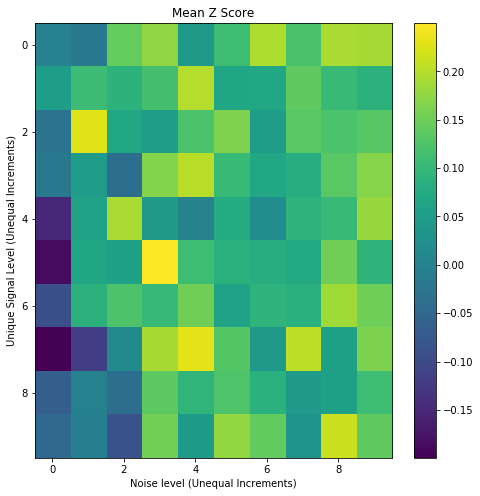

In [29]:

plt.figure(figsize=(8,8))
plt.imshow(array_1,aspect='auto')
plt.title('Mean Z Score')
plt.xlabel('Noise level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


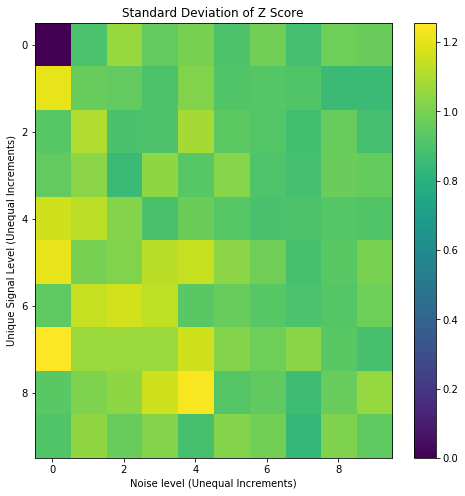

In [30]:

plt.figure(figsize=(8,8))
plt.imshow(array_2,aspect='auto')
plt.title('Standard Deviation of Z Score')
plt.xlabel('Noise level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


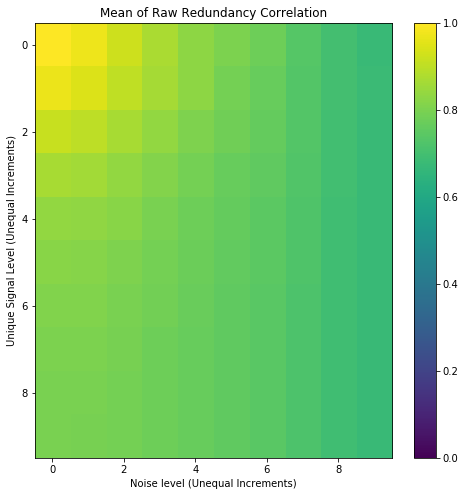

In [31]:

plt.figure(figsize=(8,8))
#plt.imshow(array_3,aspect='auto')
plt.imshow(array_3,aspect='auto',vmax = 1, vmin = 0)
plt.title('Mean of Raw Redundancy Correlation')
plt.xlabel('Noise level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


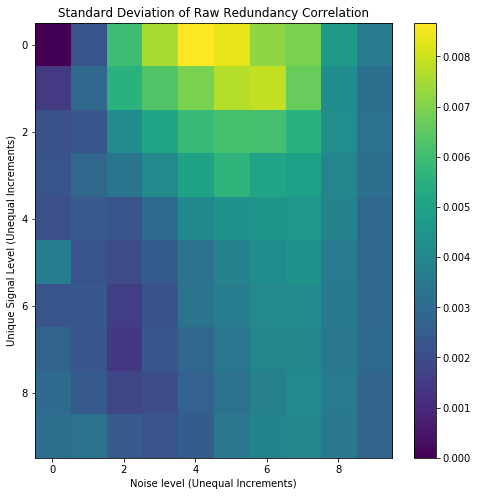

In [32]:

plt.figure(figsize=(8,8))
plt.imshow(array_4,aspect='auto')
plt.title('Standard Deviation of Raw Redundancy Correlation')
plt.xlabel('Noise level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


In [33]:

slice_1 = []
slice_2 = []
slice_3 = []


for i in holder_array:
    
    slice_1.append(i[0][2])
    
    slice_2.append(i[4][2])
    
    slice_3.append(i[9][2])
    

In [34]:

err_1 = []
err_2 = []
err_3 = []

for i in holder_array:
    
    err_1.append(i[0][3])
    
    err_2.append(i[4][3])
    
    err_3.append(i[9][3])


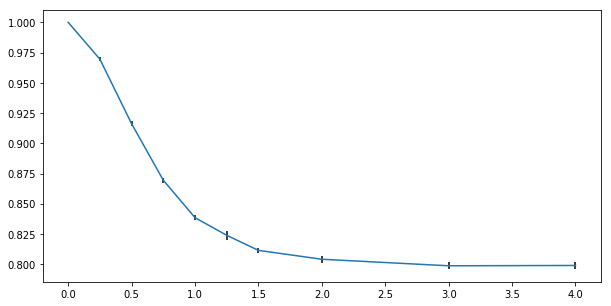

In [37]:

plt.figure(figsize = (10,5))
plt.errorbar(i_vals,slice_1,yerr=err_1,ecolor = 'k')

plt.show()


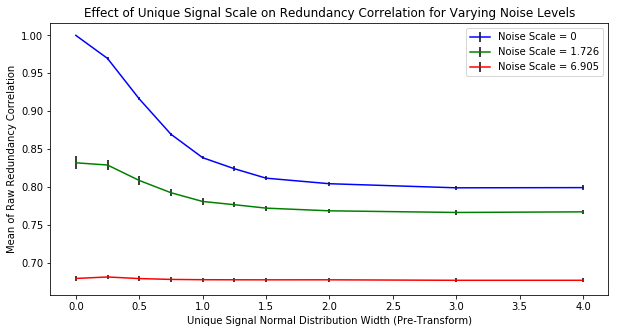

In [36]:

plt.figure(figsize = (10,5))
plt.errorbar(i_vals,slice_1,yerr=err_1,ecolor = 'k',c = 'b',label = 'Noise Scale = 0')
plt.errorbar(i_vals,slice_2,yerr=err_2,ecolor = 'k',c = 'g',label = 'Noise Scale = 1.726')
plt.errorbar(i_vals,slice_3,yerr=err_3,ecolor = 'k',c = 'r',label = 'Noise Scale = 6.905')
plt.xlabel('Unique Signal Normal Distribution Width (Pre-Transform)')
plt.ylabel('Mean of Raw Redundancy Correlation')
plt.legend()
plt.title('Effect of Unique Signal Scale on Redundancy Correlation for Varying Noise Levels')
plt.show()


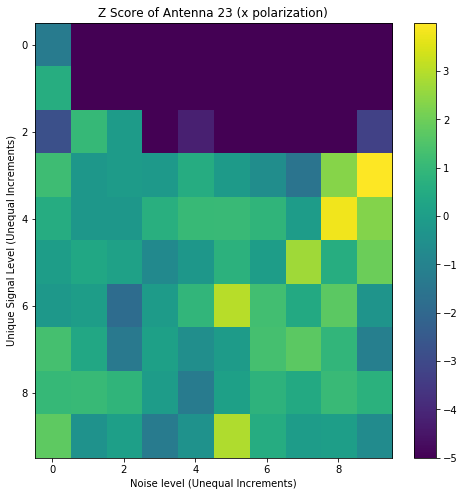

In [48]:

plt.figure(figsize=(8,8))
plt.imshow(array_1,aspect='auto',vmin = -5)
plt.title('Z Score of Antenna 23 (x polarization)')
plt.xlabel('Noise level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


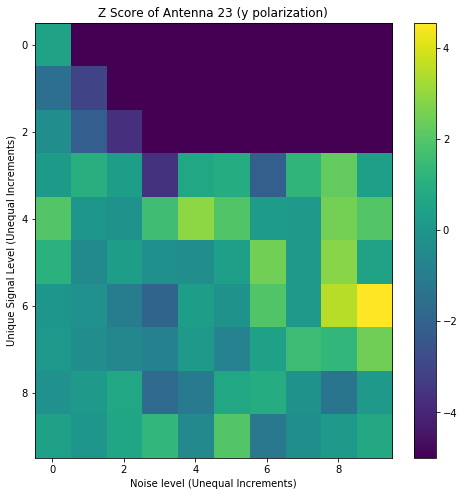

In [49]:

plt.figure(figsize=(8,8))
plt.imshow(array_2,aspect='auto',vmin = -5)
plt.title('Z Score of Antenna 23 (y polarization)')
plt.xlabel('Noise level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


In [41]:

avg_array = np.zeros((10,10))

for i in range(len(array_1)):
    
    for j in range(len(array_1[0])):
        
        avg_array[i,j] = (array_1[i][j]+array_2[i][j])/2.
 

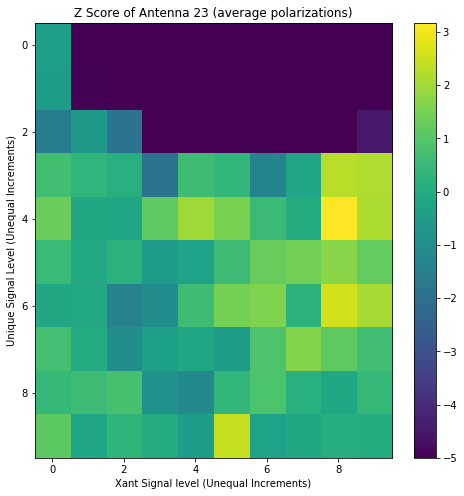

In [42]:

plt.figure(figsize=(8,8))
plt.imshow(avg_array,aspect='auto', vmin = -5)
plt.title('Z Score of Antenna 23 (average polarizations)')
plt.xlabel('Xant Signal level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


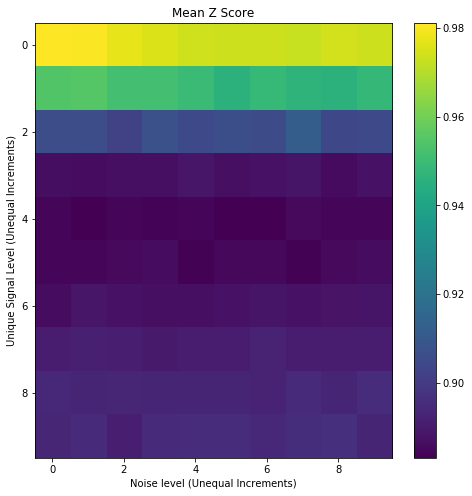

In [38]:

plt.figure(figsize=(8,8))
plt.imshow(array_3,aspect='auto')
plt.title('Mean Z Score')
plt.xlabel('Noise level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


In [43]:

slice_0 = []
slice_1 = []
slice_2 = []
slice_3 = []
slice_4 = []
slice_5 = []


for i in range(len(holder_array)):
    
    slice_0.append(holder_array[0][i][0])
    slice_1.append(holder_array[1][i][0])
    slice_2.append(holder_array[2][i][0])
    slice_3.append(holder_array[3][i][0])
    slice_4.append(holder_array[4][i][0])
    slice_5.append(holder_array[5][i][0])
    

In [44]:

avg_0 = []
avg_1 = []
avg_2 = []
avg_3 = []
avg_4 = []
avg_5 = []


for i in range(len(avg_array)):
    
    avg_0.append(avg_array[0][i])
    avg_1.append(avg_array[1][i])
    avg_2.append(avg_array[2][i])
    avg_3.append(avg_array[3][i])
    avg_4.append(avg_array[4][i])
    avg_5.append(avg_array[5][i])

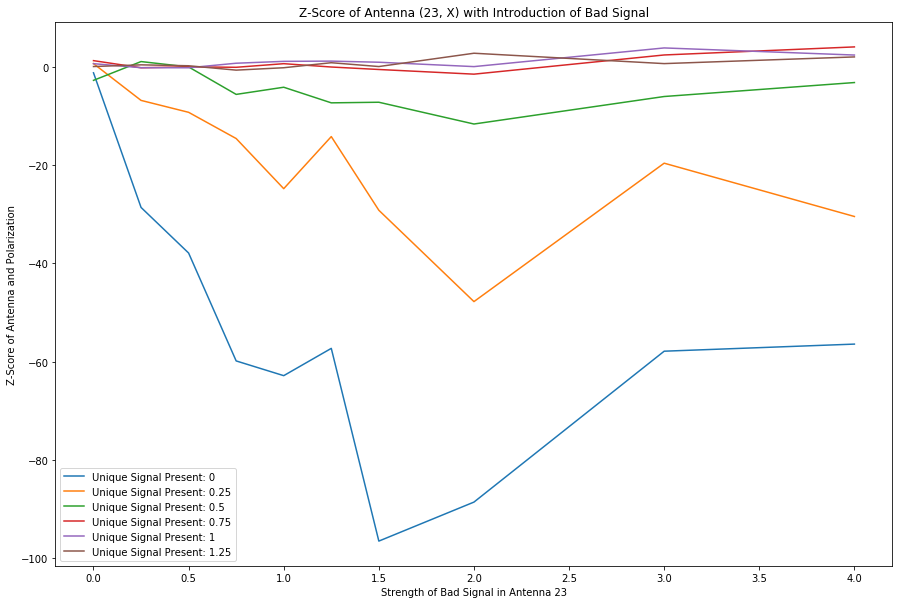

In [45]:

plt.figure(figsize = (15,10))
plt.plot(x_vals,slice_0, label = "Unique Signal Present: 0")
plt.plot(x_vals,slice_1, label = "Unique Signal Present: 0.25")
plt.plot(x_vals,slice_2, label = "Unique Signal Present: 0.5")
plt.plot(x_vals,slice_3, label = "Unique Signal Present: 0.75")
plt.plot(x_vals,slice_4, label = "Unique Signal Present: 1")
plt.plot(x_vals,slice_5, label = "Unique Signal Present: 1.25")
plt.xlabel('Strength of Bad Signal in Antenna 23')
plt.ylabel('Z-Score of Antenna and Polarization')
plt.title('Z-Score of Antenna (23, X) with Introduction of Bad Signal')
plt.legend()
plt.show()

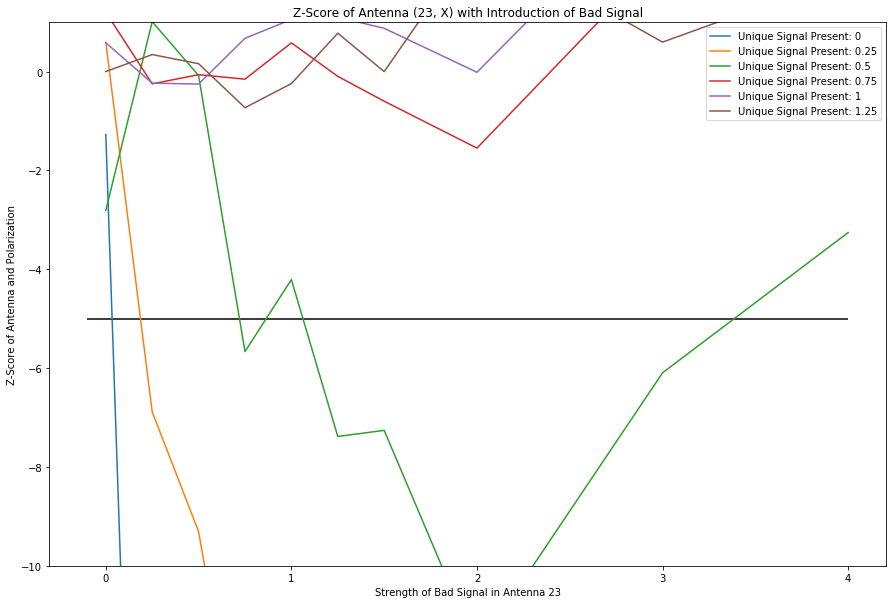

In [46]:

plt.figure(figsize = (15,10))
plt.plot(x_vals,slice_0, label = "Unique Signal Present: 0")
plt.plot(x_vals,slice_1, label = "Unique Signal Present: 0.25")
plt.plot(x_vals,slice_2, label = "Unique Signal Present: 0.5")
plt.plot(x_vals,slice_3, label = "Unique Signal Present: 0.75")
plt.plot(x_vals,slice_4, label = "Unique Signal Present: 1")
plt.plot(x_vals,slice_5, label = "Unique Signal Present: 1.25")
plt.xlabel('Strength of Bad Signal in Antenna 23')
plt.ylabel('Z-Score of Antenna and Polarization')
plt.title('Z-Score of Antenna (23, X) with Introduction of Bad Signal')
plt.hlines(-5,-0.1,4)
plt.ylim((-10,1))
plt.legend()
plt.show()

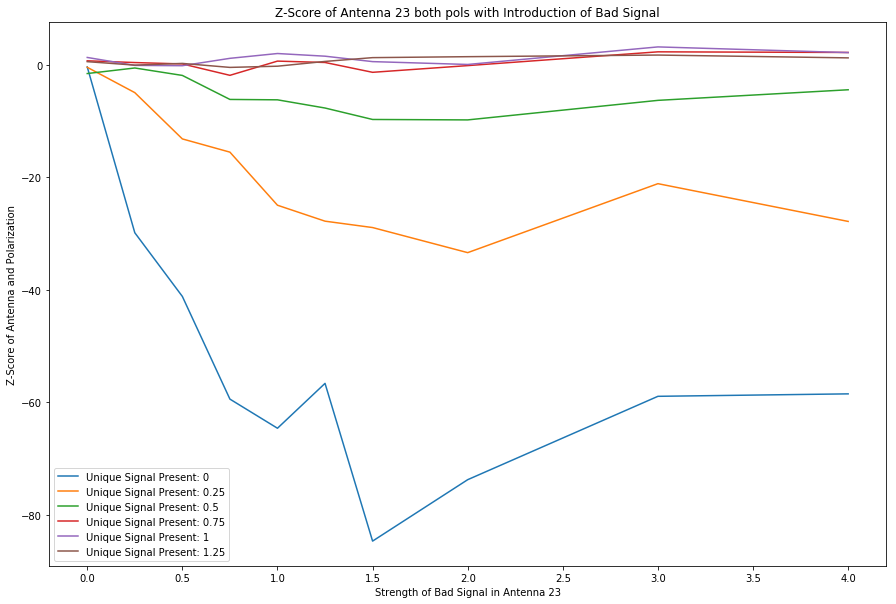

In [52]:

plt.figure(figsize = (15,10))
plt.plot(x_vals,avg_0, label = "Unique Signal Present: 0")
plt.plot(x_vals,avg_1, label = "Unique Signal Present: 0.25")
plt.plot(x_vals,avg_2, label = "Unique Signal Present: 0.5")
plt.plot(x_vals,avg_3, label = "Unique Signal Present: 0.75")
plt.plot(x_vals,avg_4, label = "Unique Signal Present: 1")
plt.plot(x_vals,avg_5, label = "Unique Signal Present: 1.25")
plt.xlabel('Strength of Bad Signal in Antenna 23')
plt.ylabel('Z-Score of Antenna and Polarization')
plt.title('Z-Score of Antenna 23 both pols with Introduction of Bad Signal')
plt.legend()
plt.show()

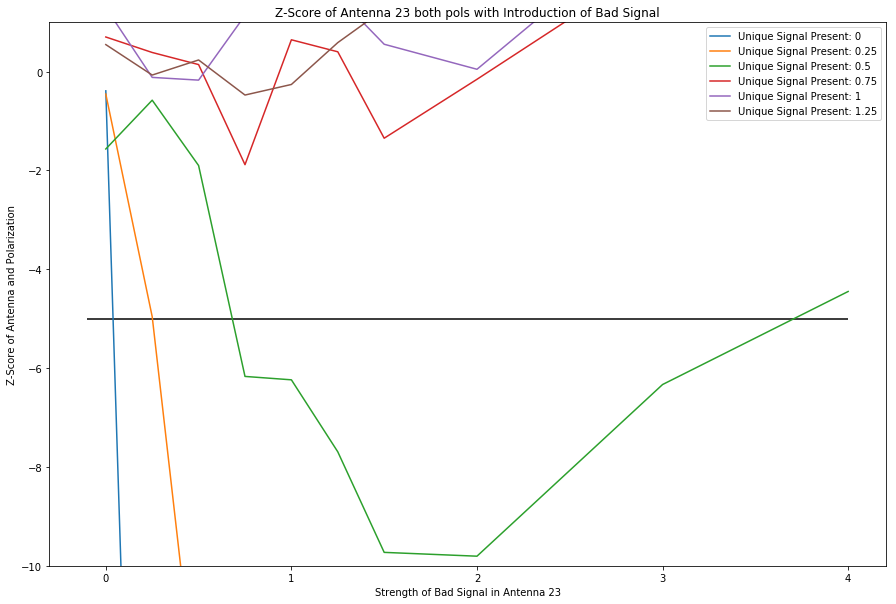

In [51]:

plt.figure(figsize = (15,10))
plt.plot(x_vals,avg_0, label = "Unique Signal Present: 0")
plt.plot(x_vals,avg_1, label = "Unique Signal Present: 0.25")
plt.plot(x_vals,avg_2, label = "Unique Signal Present: 0.5")
plt.plot(x_vals,avg_3, label = "Unique Signal Present: 0.75")
plt.plot(x_vals,avg_4, label = "Unique Signal Present: 1")
plt.plot(x_vals,avg_5, label = "Unique Signal Present: 1.25")
plt.xlabel('Strength of Bad Signal in Antenna 23')
plt.ylabel('Z-Score of Antenna and Polarization')
plt.title('Z-Score of Antenna 23 both pols with Introduction of Bad Signal')
plt.hlines(-5,-0.1,4)
plt.ylim((-10,1))
plt.legend()
plt.show()